<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html Project1.do.txt  -->
<!-- dom:TITLE: Project 1 on Machine Learning, deadline October 9 (midnight), 2023 -->

# Code for Project 1

By Erlend Lemva Ousdal, Kristen Joy Valseth, Vilde Gahr Sturtzel Lunde

This notebook contains the code used for the model development. See Project1_Illustrations for illustrations.

## Part e): Bias-variance trade-off and resampling techniques

### Franke function

This code contains the bias-variance trade-off for the Franke function

Shape: (8000, 1)
Polynomial degree: 0
Error: 0.07876309767292511
Bias^2: 0.0787506981485293
Var: 1.2399524395810506e-05
0.07876309767292511 >= 0.0787506981485293 + 1.2399524395810506e-05 = 0.07876309767292511
Shape: (8000, 3)
Polynomial degree: 1
Error: 0.023748241388546514
Bias^2: 0.02373894648706459
Var: 9.294901481921766e-06
0.023748241388546514 >= 0.02373894648706459 + 9.294901481921766e-06 = 0.02374824138854651
Shape: (8000, 6)
Polynomial degree: 2
Error: 0.01833178155197582
Bias^2: 0.01831996316578645
Var: 1.1818386189369806e-05
0.01833178155197582 >= 0.01831996316578645 + 1.1818386189369806e-05 = 0.018331781551975818
Shape: (8000, 10)
Polynomial degree: 3
Error: 0.00799585948504314
Bias^2: 0.00798545907025243
Var: 1.0400414790713221e-05
0.00799585948504314 >= 0.00798545907025243 + 1.0400414790713221e-05 = 0.007995859485043142
Shape: (8000, 15)
Polynomial degree: 4
Error: 0.00402885135379948
Bias^2: 0.004018757847490886
Var: 1.0093506308593131e-05
0.00402885135379948 >= 0.0040187

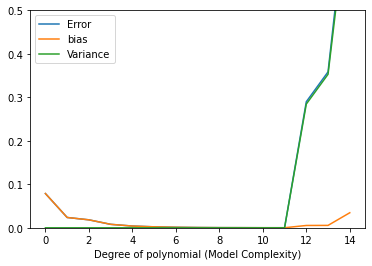

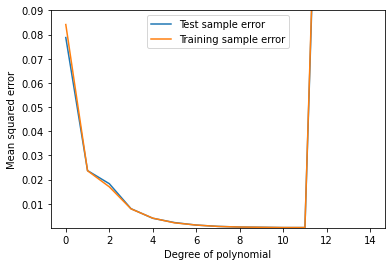

In [20]:
#Plots of bias-variance trade off and comparison of training vs test data error of franke function
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error

n_boostraps = 50
maxdegree = 15

# Generating the data set
x = np.arange(0, 1, 0.01)
y = np.arange(0, 1, 0.01)
x, y = np.meshgrid(x, y)
def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2) ** 2) - 0.25 * ((9 * y - 2) ** 2))
    term2 = 0.75 * np.exp(-((9 * x + 1) ** 2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7) ** 2 / 4.0 - 0.25 * ((9 * y - 3) ** 2))
    term4 = -0.2 * np.exp(-(9 * x - 4) ** 2 - (9 * y - 7) ** 2)
    return term1 + term2 + term3 + term4

noise = 0.01 #Changed from zero as I got nan on statistics alot
z = FrankeFunction(x, y) + noise * np.random.randn(100) # the additional term is the noise. Adjust the factor by a small number (<<1)

# Making the data into lists
x_flat = x.flatten() 
y_flat = y.flatten() 
z_flat = z.flatten()    

#Function to create design matric (Code from: https://nucleartalent.github.io/MachineLearningECT/doc/ProjectsExercises/2020/hw3/html/hw3.html)
def create_X(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
    return X

#Creating empty datasets
error = np.zeros(maxdegree)
ztilde = np.zeros(maxdegree)
train_error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)


for degree in range(maxdegree):
    #Create design matrix
    X = create_X(x_flat, y_flat, n=degree)  
    #split data into training and test datasets for bootstrapping
    x_train, x_test, z_train, z_test = train_test_split(X, z_flat, test_size=0.2)
    ztilde = np.empty((x_train.shape[0], n_boostraps))
    zpredict = np.empty((z_test.shape[0], n_boostraps))
    #Fit model for n_bootstraps
    for k in range(n_boostraps):
        x_, y_ = resample(x_train, z_train)
        beta =  np.linalg.inv(x_.T @ x_) @ x_.T @ y_
        zpredict[:, k] = x_test @ beta
        ztilde[:,k] = x_train @ beta
    polydegree[degree] = degree
    z_test = np.reshape(z_test,(len(z_test),1))
    z_train = np.reshape(z_train,(len(z_train),1))
    #Take mean of n_bootstrapping results
    error[degree] = np.mean( np.mean((z_test - zpredict)**2, axis=1, keepdims=True) )
    train_error[degree] = np.mean( np.mean((z_train - ztilde)**2, axis=1, keepdims=True) )
    bias[degree] = np.mean( (z_test - np.mean(zpredict, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean( np.var(zpredict, axis=1, keepdims=True) )
    print('Shape:', x_train.shape)
    print('Polynomial degree:', degree)
    print('Error:', error[degree])
    print('Bias^2:', bias[degree])
    print('Var:', variance[degree])
    print('{} >= {} + {} = {}'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))
 

#Plot of bias-variance tradeoff 
plt.plot(polydegree, error, label='Error')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='Variance')
plt.axis(ymin = 0, ymax = 0.5)
plt.xlabel('Degree of polynomial (Model Complexity)')
plt.legend()
plt.savefig('Bias_Var_Tradeoff.png', format='png')
plt.show()

#Plot of training vs test data error
plt.plot(polydegree, error, label='Test sample error')
plt.plot(polydegree, train_error, label='Training sample error')
plt.legend()
plt.axis(ymin = 0.00009, ymax = 0.09)
plt.xlabel('Degree of polynomial')
plt.ylabel('Mean squared error')
plt.savefig('Train_vs_Test_data.png', format='png')
plt.show()

### Terrain data

This code contains the bias-variance trade-off for the terrain data.

In [ ]:
#Plots of Bias-variance trade off and comparison of training vs test data error of terrain data
import matplotlib.pyplot as plt
import numpy as np
from imageio import imread
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error

n_boostraps = 100
maxdegree = 11

# Load the terrain
terrain = imread('/home/Kristen/Documents/FYS4155/MachineLearning/doc/Projects/2023/Project1/DataFiles/SRTM_data_Norway_1.tif')
#terrain2 = imread('SRTM_data_Norway_2.tif')

N = 1000
terrain = terrain[:N,:N]
# Creates mesh of image pixels
x = np.linspace(0,1, np.shape(terrain)[0])
y = np.linspace(0,1, np.shape(terrain)[1])
x_mesh, y_mesh = np.meshgrid(x,y)

x_flat = x_mesh.flatten()
y_flat = y_mesh.flatten()
z = terrain
z_flat = z.flatten()

#Function to create design matric (Code from: https://nucleartalent.github.io/MachineLearningECT/doc/ProjectsExercises/2020/hw3/html/hw3.html)
def create_X(x, y, n ):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
    return X

#Creating empty datasets
error = np.zeros(maxdegree)
ztilde = np.zeros(maxdegree)
train_error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)


for degree in range(maxdegree):
    #Create design matrix
    X = create_X(x_flat, y_flat, n=degree)  
    #split data into training and test datasets for bootstrapping
    x_train, x_test, z_train, z_test = train_test_split(X, z_flat, test_size=0.2)
    ztilde = np.empty((x_train.shape[0], n_boostraps))
    zpredict = np.empty((z_test.shape[0], n_boostraps))
    #Fit model for n_bootstraps
    for k in range(n_boostraps):
        x_, y_ = resample(x_train, z_train)
        beta =  np.linalg.inv(x_.T @ x_) @ x_.T @ y_
        zpredict[:, k] = x_test @ beta
        ztilde[:,k] = x_train @ beta
    polydegree[degree] = degree
    z_test = np.reshape(z_test,(len(z_test),1))
    z_train = np.reshape(z_train,(len(z_train),1))
    #Take mean of n_bootstrapping results
    error[degree] = np.mean( np.mean((z_test - zpredict)**2, axis=1, keepdims=True) )
    train_error[degree] = np.mean( np.mean((z_train - ztilde)**2, axis=1, keepdims=True) )
    bias[degree] = np.mean( (z_test - np.mean(zpredict, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean( np.var(zpredict, axis=1, keepdims=True) )
    print('Shape:', x_train.shape)
    print('Polynomial degree:', degree)
    print('Error:', error[degree])
    print('Bias^2:', bias[degree])
    print('Var:', variance[degree])
    print('{} >= {} + {} = {}'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))
 

#Plot of bias-variance tradeoff 
plt.plot(polydegree, error, label='Error')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='Variance')
plt.xlabel('Degree of polynomial (Model Complexity)')
plt.legend()
plt.savefig('Bias_Var_Tradeoff.png', format='png')
plt.show()

#Plot of training vs test data error
plt.plot(polydegree, error, label='Test sample error')
plt.plot(polydegree, train_error, label='Training sample error')
plt.legend()
plt.xlabel('Degree of polynomial')
plt.ylabel('Mean squared error')
plt.savefig('Train_vs_Test_data.png', format='png')
plt.show()

Shape: (800000, 1)
Polynomial degree: 0
Error: 22023.904170553637
Bias^2: 22023.88607024339
Var: 0.018100310246601733
22023.904170553637 >= 22023.88607024339 + 0.018100310246601733 = 22023.904170553637
Shape: (800000, 3)
Polynomial degree: 1
Error: 16424.784885976616
Bias^2: 16424.724981378466
Var: 0.0599045981457792
16424.784885976616 >= 16424.724981378466 + 0.0599045981457792 = 16424.784885976613
Shape: (800000, 6)
Polynomial degree: 2
Error: 11997.333057490807
Bias^2: 11997.23546872798
Var: 0.09758876283071637
11997.333057490807 >= 11997.23546872798 + 0.09758876283071637 = 11997.33305749081
Shape: (800000, 10)
Polynomial degree: 3
Error: 11550.54800245708
Bias^2: 11550.378133061196
Var: 0.1698693958821815
11550.54800245708 >= 11550.378133061196 + 0.1698693958821815 = 11550.548002457079


## Part f):  Cross-validation as resampling techniques

0.006924705660030525 0.00686513623789931 0.0
0.002331503521966094 0.002322737361328191 0.0
0.002727774674235043 0.0012808304747313033 0.0


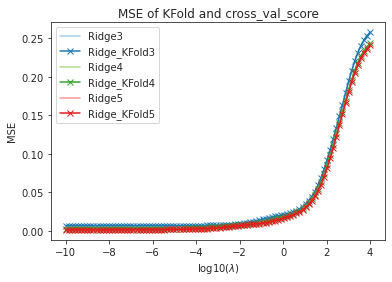

In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import make_scorer, mean_squared_error
import seaborn as sns
sns.set_style("ticks")
palette = sns.color_palette("Paired")
sns.set_palette(palette)


def KFoldCV(X,z, lmb, model, kfold):
    OLS = LinearRegression()
    ridge = Ridge(lmb, fit_intercept= False)
    lasso = Lasso(lmb, fit_intercept = False, tol = 0.01)
    
    scores_KFold = np.zeros(kfold.get_n_splits(X))
    
    
    j = 0
    for train_inds, test_inds in kfold.split(X):
       
        
        xtrain = X[train_inds]
        ytrain = z[train_inds]
        
        xtest = X[test_inds]
        ytest = z[test_inds]
       
        
        if(model == "OLS"):
            OLS.fit(xtrain, ytrain)
            ypred = OLS.predict(xtest)
        if(model == "Ridge"):
            #Xtrain = poly.fit_transform(xtrain[:, np.newaxis].reshape(xtrain.shape))
            ridge.fit(xtrain, ytrain)
            #Xtest = poly.fit_transform(xtest[:, np.newaxis].reshape(xtest.shape))
            ypred = ridge.predict(xtest)
        if(model == "Lasso"):
            #Xtrain = poly.fit_transform(xtrain[:, np.newaxis].reshape(xtrain.shape))
            lasso.fit(xtrain, ytrain)
            ypred = lasso.predict(xtest)
            #Xtest = poly.fit_transform(xtest[:, np.newaxis].reshape(xtest.shape))
        
        scores_KFold[j] = np.sum((ypred - ytest)**2)/np.size(ypred)
        
        j += 1
    MSE = np.mean(scores_KFold)
    return(MSE)

# Making the R2 and MSE functions
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

# Generating the data set
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x, y)
def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2) ** 2) - 0.25 * ((9 * y - 2) ** 2))
    term2 = 0.75 * np.exp(-((9 * x + 1) ** 2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7) ** 2 / 4.0 - 0.25 * ((9 * y - 3) ** 2))
    term4 = -0.2 * np.exp(-(9 * x - 4) ** 2 - (9 * y - 7) ** 2)
    return term1 + term2 + term3 + term4

noise = 0
z = FrankeFunction(x, y) + noise * np.random.randn(20) # the additional term is the noise. Adjust the factor by a small number (<<1)

# Making the data into lists
x_flat = x.flatten()
y_flat = y.flatten()
z_flat = z.flatten()



def fit(degree_x, degree_y):
    X = np.zeros((len(x_flat), (degree_x+1)*(degree_y+1)))
    poly = PolynomialFeatures(degree = degree_x)
    k = 5
    kfold = KFold(n_splits = k, shuffle=True, random_state = 42)
    col_idx = 0
    for i in range(degree_x + 1):
        for j in range(degree_y + 1):
            X[:, col_idx] = x_flat**i * y_flat**j
            col_idx += 1
    X_train, X_test, z_train, z_test = train_test_split(X, z_flat, test_size=0.2)
    
    
    
    
    I = np.eye((degree_x+1)*(degree_y+1),(degree_x+1)*(degree_y+1))
    nlambdas = 100
    
    MSERidgePredict = np.zeros(nlambdas)
    MSERidgeTrain = np.zeros(nlambdas)
    MSELassoPredict = np.zeros(nlambdas)
    MSELassoTrain = np.zeros(nlambdas)
    MSEdiffPredict = np.zeros(nlambdas)
    MSEdiffTrain = np.zeros(nlambdas)
    
    MSEOLS = np.zeros(nlambdas)
    MSERidge = np.zeros(nlambdas)
    MSELasso = np.zeros(nlambdas)
    
    MSEKFold_OLS = np.zeros(nlambdas)
    MSEKFold_ridge = np.zeros((nlambdas))
    MSEKFold_lasso = np.zeros(nlambdas)
    lambdas = np.logspace(-10, 4, nlambdas)
    for i in range(nlambdas):
        
        lmb = lambdas[i]
        
        #models
        linreg = LinearRegression()
        ridge = Ridge(lmb, fit_intercept = False)
        lasso = Lasso(lmb, fit_intercept = False, tol = 0.01)
        
        #scorings
        
        #XCV = poly.fit_transform(X[:, np.newaxis].reshape(X.shape))
        mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
        linscores = cross_val_score(linreg, X_train, z_train, scoring=mse_scorer,  cv = kfold)
        ridgescores = cross_val_score(ridge, X_train, z_train, scoring=mse_scorer, cv = kfold)
        #lassoscores = cross_validate(lasso, X_train, z_train, scoring=mse_scorer, return_estimator = True, cv = kfold)
        
        #printing scores of CV for sklearn
        #print("OLS: " + str(linscores["test_score"].mean()))
        #print("Ridge: " + str(ridgescores["test_score"].mean()))
        #print("Lasso: " + str(lassoscores["test_score"].mean()))
        
        #storing scores of CV from sklearn
        MSEOLS[i] = np.mean(-linscores)
        MSERidge[i] = np.mean(-ridgescores)
        #MSELasso[i] = -lassoscores["test_score"].mean()
        
        
        #OLS
        #MSEKFold_OLS[i] = KFoldCV(X_train, z_train, lmb, "OLS", kfold)
        
        #Ridge
        
        MSEKFold_ridge[i] = KFoldCV(X_train, z_train, lmb, "Ridge", kfold)
        
        """
        ridge = Ridge(lmb)
        Ridgebeta = np.linalg.inv(X_train.T @ X_train+lmb*I) @ X_train.T @ z_train
        ztildeRidge = X_train @ Ridgebeta
        zpredictRidge = X_test @ Ridgebeta
        MSERidgePredict[i] = MSE(z_test, zpredictRidge)
        MSERidgeTrain[i] = MSE(z_train, ztildeRidge)
        #MSEKFold_ridge[i] = KFoldCV(X_train, z_train, lmb, "Ridge", k)
        """
        #Lasso
        
        #MSEKFold_lasso[i] = KFoldCV(X_train, z_train, lmb, "Lasso", kfold)
        """
        RegLasso = linear_model.Lasso(lmb,fit_intercept=False)
        RegLasso.fit(X_train, z_train)
        ztildeLasso = RegLasso.predict(X_train)
        zpredictLasso = RegLasso.predict(X_test)
        MSELassoPredict[i] = MSE(z_test,zpredictLasso)
        MSELassoTrain[i] = MSE(z_train,ztildeLasso)
        """
        #Difference
        #MSEdiffPredict[i] = MSELassoPredict[i] - MSERidgePredict[i]
        #MSEdiffTrain[i] = MSELassoTrain[i] - MSERidgeTrain[i]
        
    #Plotting
    #plt.plot(np.log10(lambdas), MSEdiffPredict, label = 'Test, degree:' + str(degree_x))
    #plt.plot(np.log10(lambdas), MSEdiffTrain, linestyle = '--', label = 'Train, degree:' + str(degree_x))
    
    #plt.plot(np.log10(lambdas), MSEOLS, label = 'OLS' + str(degree_x))
    #plt.plot(np.log10(lambdas), MSEKFold_OLS, 'x-', label = 'OLS_KFold' + str(degree_x))
    
    plt.plot(np.log10(lambdas), MSERidge, label = 'Ridge' + str(degree_x))
    plt.plot(np.log10(lambdas), MSEKFold_ridge, 'x-', label = 'Ridge_KFold' + str(degree_x))
    
    #plt.plot(np.log10(lambdas), MSELasso, 'x-', label = "Lasso")
    #plt.plot(np.log10(lambdas), MSEKFold_lasso, label = 'Lasso_KFold')
    print(np.min(MSEOLS), np.min(MSERidge), np.min(MSELasso))



for n in range(3,6):
    fit(n,n)
plt.xlabel('log10($\lambda$)')
plt.ylabel('MSE')
plt.title('MSE of KFold and cross_val_score')
plt.legend()
plt.show()